In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import requests
import pytz
import os
from functools import reduce

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt

C:\Users\HP\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
pwd

'C:\\Users\\HP\\Documents\\Momentum_portfolio'

In [4]:
def fetch_data(ticker,start,end):
    price_data = pd.read_excel('price_data.xlsx')
    price_data.rename(columns={'Unnamed: 0':'Date'},inplace=True)
    price_data.set_index('Date', inplace=True)
    price_data = price_data.T
    price_data.index = pd.to_datetime(price_data.index)
    price_data = price_data[ticker]
    price_data = price_data.loc[start:end]
    return price_data#np.round(price_data,2)

In [5]:
def get_index_data(start,end):
    
    index = pd.read_csv("BSE100.csv",index_col=False)
    index.index = pd.to_datetime(index['Date'])
    index.rename(columns={'Close':'PX_LAST'},inplace=True)
    index = index[['PX_LAST']]
    index = index.loc[start:end]
#     display(index)
    return index   

In [6]:
def calc_daily_nav(ret_list, prev_nav):
    df = ret_list.cumsum()+1
    return [(ret*prev_nav) for ret in df]

In [7]:
def calc_perf(portfolio,test_start,test_end,train_start,train_end):   
    row = []
    ret_row = []
    # get and calulate index returns
    index = get_index_data(test_start,test_end)
    index_rets = index.pct_change()
#     display(index_rets)
    row.append(cal_cumret(index_rets['PX_LAST']))
    row.append(cal_sharpe(index_rets['PX_LAST']))
    row.append(cal_max_drawdown(index_rets['PX_LAST']))
    
    # In sample dataset to generate stock weights
    df1 = pd.DataFrame()
    for y in portfolio:
        df1[y] = fetch_data(y,train_start,train_end)    
    
    
    # Out of sample dataset to test portfolio metrics
    df2 = pd.DataFrame()
    for k in portfolio:
        df2[k] = fetch_data(k,test_start,test_end)
        

    
    ## S is annualised covariance
    ## mu is annaualised return
    
    daily_returns = df1.pct_change()
    annualized_daily_returns = daily_returns.mean() * 250
    
    daily_covariance = daily_returns.cov()
    annualized_covariance = daily_covariance * 250
    S = annualized_covariance
    mu = annualized_daily_returns
    
    
    # Out of sample returns
    train_returns = df1.pct_change()
    test_returns = df2.pct_change()
    test_returns2 = df2.pct_change()
    dates_lst = index_rets.index.to_list()
    
    rp_wts, min_variance_port = get_weights(train_returns, S,mu, portfolio)
    
    for ticker in test_returns.columns:
        test_returns[ticker] = rp_wts[ticker] * test_returns[ticker]
    test_returns['rp_out_of_sample_ret'] = test_returns.sum(axis=1)
    #display(test_returns)
    row.append(cal_cumret(test_returns['rp_out_of_sample_ret']))
    row.append(cal_sharpe(test_returns['rp_out_of_sample_ret']))
    row.append(cal_max_drawdown(test_returns['rp_out_of_sample_ret']))
    
    EQ_W = test_returns2.mean(axis=1)
    row.append(cal_cumret(EQ_W))
    row.append(cal_sharpe(EQ_W))
    row.append(cal_max_drawdown(EQ_W))
    
    min_vol_weights = min_variance_port.iloc[:,3:]
    for ticker in test_returns2.columns:
        test_returns2[ticker] = min_vol_weights[ticker].values[0] * test_returns2[ticker]
    test_returns2['min_vol_out_of_sample_ret'] = test_returns2.sum(axis=1)
    
    row.append(cal_cumret(test_returns2['min_vol_out_of_sample_ret']))
    row.append(cal_sharpe(test_returns2['min_vol_out_of_sample_ret']))
    row.append(cal_max_drawdown(test_returns2['min_vol_out_of_sample_ret']))
    
    index_rets['date'] = dates_lst
    test_returns['date'] = test_returns.index    
#     EQ_W['date'] = EQ_W.index
    test_returns2['date'] = test_returns2.index

    ret_row.extend([index_rets[['date','PX_LAST']], test_returns[['date','rp_out_of_sample_ret']], EQ_W, test_returns2[['date','min_vol_out_of_sample_ret']]])
    
#     idx_nav = calc_daily_nav(index_rets['PX_LAST'], prev_nav_lst[0])
#     idx_nav = pd.DataFrame(idx_nav, index=index_rets.index,columns=['idx_nav'])
#     portfolio_nav = calc_daily_nav(test_returns['rp_out_of_sample_ret'], prev_nav_lst[1])
#     portfolio_nav = pd.DataFrame(portfolio_nav, index=test_returns.index,columns=['portfolio_nav'])
    
#     ew_nav=calc_daily_nav(EQ_W, prev_nav_lst[2])
#     ew_nav = pd.DataFrame(ew_nav,index=EQ_W.index, columns=['ew_nav'])

#     min_vol_nav=calc_daily_nav(test_returns2['min_vol_out_of_sample_ret'], prev_nav_lst[3])
#     min_vol_nav = pd.DataFrame(min_vol_nav,index=test_returns2.index, columns=['min_vol_nav'])
#     nav_df = pd.concat([idx_nav,portfolio_nav,ew_nav,min_vol_nav], axis=1).fillna(method='ffill').dropna()
#     prev_nav_lst = [idx_nav.iloc[-1],portfolio_nav.iloc[-1],ew_nav.iloc[-1],min_vol_nav.iloc[-1]]    
    
    return row, rp_wts, min_vol_weights, ret_row, EQ_W

In [8]:
def get_weights(returns_daily,S,mu, portfolio):    
    #risk parity weights
    print(len(returns_daily))
    def hist_vol(data_val):
        data_val = data_val.std() * np.sqrt(252)
        return data_val

    h_vols = hist_vol(returns_daily)

    wts = (1/h_vols).apply(lambda x: x/((1/h_vols).sum())) ## calculating risk parity weights    
    
    # get daily and covariance of returns of the stock
    selected = portfolio
    cov_annual = S
    returns_annual = mu

  # empty lists to store returns, volatility and weights of imiginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

  # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = 1000

#    #set random seed for reproduction's sake
    np.random.seed(101)

#    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = returns / volatility
        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)

   # a dictionary for Returns and Risk values of each portfolio
        portfolio_s = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

   # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter,symbol in enumerate(selected):
        
        portfolio_s[symbol] = [Weight[counter] for Weight in stock_weights]
      
    df = pd.DataFrame(portfolio_s)

 
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in selected]

#     # reorder dataframe columns 
    df = df[column_order]

 
#     # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = df['Volatility'].min()
#     max_sharpe = df['Sharpe Ratio'].max()

#     # use the min, max values to locate and create the two special portfolios
#     sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]
    
#     return sharpe_portfolio, min_variance_port, returns_annual
    return wts, min_variance_port
    

In [9]:
def cal_cumret(ret_lst):
    #return round(((pd.DataFrame({'ret':ret_lst})['ret']+1).cumprod()-1)[-1] * 100, 2)
    return round(((pd.DataFrame({'ret':ret_lst})['ret']).cumsum())[-1] * 100, 2)

In [10]:
def cal_sharpe(ret_lst):
    ret_lst= ret_lst[1:]
    return round((ret_lst.mean() * 252)/(ret_lst.std() * np.sqrt(252)),2)

In [11]:
def cal_max_drawdown(ret_lst):
#     print('dd', dt.datetime.now())
    df = pd.DataFrame({'ret':ret_lst})
    df['cumret'] = (df.ret).cumsum()
    df['highest_val'] = df.cumret.expanding().max()
    df['dd'] = 0.0
    for row, rowval in df.iterrows():
        if(rowval['highest_val'] > rowval['cumret']):
            df.loc[row, 'dd'] = rowval.cumret - rowval.highest_val
    df.dd.ffill(inplace=True)
#     print('dd', dt.datetime.now())
    return (df.dd.min() * 100)


In [12]:
result_df= pd.read_excel("quarterly_periods.xlsx")
price_data = pd.read_excel("price_data.xlsx")
result_df.dropna(inplace=True)
quarter_dict = {4:"Q1",7:"Q2", 10:"Q3",1:"Q4"}
prev_date_range = "1/4/2022 - 30/6/2022"#'2/1/2017 - 31/3/2017' #"2/1/2012 - 30/3/2012"#'1/4/2015 - 30/6/2015'
writer = pd.ExcelWriter("Low_vol_quarters_portfolio_20.xlsx")
#writer_minvol  = pd.ExcelWriter("Largecap_quarters_portfolio_minvol.xlsx")
row_lst =[]
ret_list=[]
reader_composite = pd.ExcelFile('volatility_factor_rank_nse300.xlsx')
for date_range in result_df.Date:
    print(date_range)
#     if(date_range==result_df.Date.iloc[])
    train_start = dt.datetime.strptime(prev_date_range.split(" - ")[0],"%d/%m/%Y").date()
    train_end = dt.datetime.strptime(prev_date_range.split(" - ")[1],"%d/%m/%Y").date()
    test_start= dt.datetime.strptime(date_range.split(" - ")[0],"%d/%m/%Y").date()
    test_end = dt.datetime.strptime(date_range.split(" - ")[1],"%d/%m/%Y").date()
    
    q_date = f"{train_end.strftime('%Y%m')}"  
    
    rank_df = pd.read_excel(reader_composite,sheet_name=q_date)
    rank_df.rename(columns={'Ticker':'Company Name'},inplace=True)
    rank_df.sort_values(by=['rank'],ascending=True,inplace=True)
    
    itdf = rank_df.iloc[:100,:]
    #itdf.sort_values(by=["rank"],ascending=True, inplace=True)
    stock_list = itdf['Company Name'].values
    price_df = price_data.rename(columns={'Unnamed: 0':'Company Name'})
    price_df.set_index('Company Name',inplace=True)
    
    # price_df.fillna(method='ffill',axis=1, inplace=True)
    price_df_q = price_df.loc[stock_list][dt.datetime.strptime(prev_date_range.split(" - ")[1],"%d/%m/%Y")]
    #final_portfolio = price_df_q[price_df_q<2000.0][:5].index.to_list()
    itdf = pd.DataFrame(price_df_q)
    #itdf = itdf[itdf.index!='Page Industries Ltd.']
    
    final_portfolio = itdf[:20].index.to_list()
#     final_portfolio = rank_df.loc[:29,:]['Company Name'].to_list()   
    print((final_portfolio))
#     final_portfolio=pd.DataFrame({'Ticker':final_portfolio})
    
#     portfolio_list = final_portfolio.Ticker.values
    if(quarter_dict[test_start.month] == 'Q4'):
        q_date = f'{quarter_dict[test_start.month]}{test_start.year-1}'
    else:
        q_date = f'{quarter_dict[test_start.month]}{test_start.year}'
    print(q_date)

    stats_lst,rp_wt,min_vol_weights, ret_row, eq_wt= calc_perf(final_portfolio,test_start,test_end,train_start,train_end)  
    ret_list.append(ret_row)
    
#     navdf_lst.append(nav_df) 
    #pd.DataFrame(min_vol_weights,columns=['Weights']).to_excel(writer_minvol, sheet_name=f"{q_date}")
    pd.DataFrame(rp_wt,columns=['Weights']).to_excel(writer, sheet_name=f"{q_date}")
#     pd.
    row_lst.append(stats_lst)
    prev_date_range = date_range
df = pd.DataFrame(row_lst)
writer.save() 
#writer_minvol.save()

1/4/2022 - 30/6/2022
['Narayana Hrudayalaya Ltd.', 'Emami Ltd.', 'Pfizer Ltd.', 'UCO Bank', 'Marico Ltd.', 'Alkem Laboratories Ltd.', 'Colgate-Palmolive (India) Ltd.', 'Bajaj Auto Ltd.', 'Hindustan Unilever Ltd.', 'Abbott India Ltd.', 'Supreme Industries Ltd.', 'Britannia Industries Ltd.', 'Pidilite Industries Ltd.', 'ICICI Lombard General Insurance Company Ltd.', 'Petronet LNG Ltd.', 'MRF Ltd.', 'Nestle India Ltd.', 'Bayer CropScience Ltd.', 'Relaxo Footwears Ltd.', 'Dabur India Ltd.']
Q12022
62
1/7/2022 - 30/9/2022
['Narayana Hrudayalaya Ltd.', 'Emami Ltd.', 'Pfizer Ltd.', 'UCO Bank', 'Marico Ltd.', 'Alkem Laboratories Ltd.', 'Colgate-Palmolive (India) Ltd.', 'Bajaj Auto Ltd.', 'Hindustan Unilever Ltd.', 'Abbott India Ltd.', 'Supreme Industries Ltd.', 'Britannia Industries Ltd.', 'Pidilite Industries Ltd.', 'ICICI Lombard General Insurance Company Ltd.', 'Petronet LNG Ltd.', 'MRF Ltd.', 'Nestle India Ltd.', 'Bayer CropScience Ltd.', 'Relaxo Footwears Ltd.', 'Dabur India Ltd.']
Q22022

C:\Users\HP\AppData\Local\Temp\ipykernel_32532\3754144194.py:59: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [13]:
df.columns = ['BSE100_ret','BSE100_sharpe','BSE100_DD','Risk_Parity_ret','Risk_Parity_sharpe','Risk_Parity_DD',\
             'EW_ret','EW_sharpe','EW_DD','Min_Vol_ret','Min_Vol_sharpe','Min_Vol_DD']

result_df= pd.read_excel("quarterly_periods.xlsx")
result_df.reset_index(drop=True,inplace=True)

df['Date'] = result_df['Date']

#df.to_excel('thematic_backtest_top300_composite.xlsx')

In [14]:
df

,BSE100_ret,BSE100_sharpe,BSE100_DD,Risk_Parity_ret,Risk_Parity_sharpe,Risk_Parity_DD,EW_ret,EW_sharpe,EW_DD,Min_Vol_ret,Min_Vol_sharpe,Min_Vol_DD,Date
0,-4.72,-3.23,-8.286881,-4.62,-1.53,-9.312614,-4.35,-1.41,-9.115500,-4.27,-1.53,-8.593133,1/4/2022 - 30/6/2022
1,9.55,2.72,-6.978461,8.06,2.77,-3.088793,8.10,2.74,-3.126233,7.25,2.47,-2.762587,1/7/2022 - 30/9/2022
2,6.24,2.18,-5.651994,5.59,3.00,-2.628992,5.13,2.77,-2.583817,7.14,3.41,-2.989348,3/10/2022 - 30/12/2022
3,-4.89,-1.77,-7.558186,-3.43,-2.34,-5.470096,-2.87,-1.91,-4.982185,0.57,0.34,-3.969869,2/1/2023 - 31/3/2023
4,7.38,6.75,-1.430059,6.21,7.06,-0.926105,6.80,7.27,-1.112670,6.65,7.33,-1.097310,2/4/2023 - 30/5/2023


In [13]:
df.to_excel('low_vol_perf_20.xlsx')

In [15]:
## stiching the daily returns to a continous time return series
index_list=[]
risk_parity_list=[]
ew_list=[]
min_vol_list=[]
for i in range(0,len(ret_list)):
    
    #display(ret_list[i])
    for j in range(0,len(ret_list[i])):
        if(j==0):
            index_list.append(ret_list[i][j])
        elif(j==1):
            risk_parity_list.append(ret_list[i][j])
        elif(j==2):
            ew_list.append(ret_list[i][j][:-1])
        elif(j==3):
            min_vol_list.append(ret_list[i][j])
            
ind_df=pd.concat(index_list)
risk_parity_df = pd.concat(risk_parity_list)
ew_df = pd.concat(ew_list)
ew_df = pd.DataFrame(ew_df, columns=['ew_ret'])
min_vol_df= pd.concat(min_vol_list)
ind_df.fillna(method='ffill', inplace=True)
ew_df.fillna(method='ffill', inplace=True)
ind_df.dropna(inplace=True)
risk_parity_df.dropna(inplace=True)
ew_df.dropna(inplace=True)
min_vol_df.dropna(inplace=True)   

In [16]:
ind_df['cum_ret'] = ind_df.PX_LAST.cumsum()
risk_parity_df['cum_ret'] = risk_parity_df.rp_out_of_sample_ret.cumsum()
ew_df['cum_ret'] = ew_df.ew_ret.cumsum()
min_vol_df['cum_ret'] = min_vol_df.min_vol_out_of_sample_ret.cumsum()

In [17]:
ind_df.to_excel('index_returns_top300_low_vol_20.xlsx',index=False)
risk_parity_df.to_excel('risk_parity_returns_top300_low_vol_20.xlsx', index=False)
ew_df.to_excel('ew_returns_top300_low_vol_20.xlsx' )
min_vol_df.to_excel('min_vol_returns_top300_low_vol_20.xlsx', index=True)

In [18]:
ind_df.shape,risk_parity_df.shape,ew_df.shape,min_vol_df.shape

((246, 3), (287, 3), (281, 2), (287, 3))

In [48]:
## Analyse performance metrics for all the portfolios

def backtest_analyser(strategy_returns: pd.Series, benchmark_returns: pd.Series):
    # Align the strategy and benchmark returns by merging the series on their datetime indices
    combined_df = pd.concat([strategy_returns, benchmark_returns], axis=1, join='inner')
    combined_df.columns = ['Strategy Returns', 'Benchmark Returns']
    
    # Nested functions for performance metrics
    def cumulative_return(returns):
        return (1 + returns).cumprod() - 1

    def annualised_return(returns):
        return np.prod(1 + returns) ** (252 / len(returns)) - 1

    def sharpe_ratio(returns, risk_free_rate=0):
        excess_returns = returns - risk_free_rate / 252
        return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

    def max_drawdown(returns):
        cum_returns = cumulative_return(returns)
        running_max = cum_returns.cummax()
        drawdown = cum_returns - running_max
        max_dd = drawdown.min()
        return max_dd, (drawdown == max_dd).idxmax()

    def max_drawdown_duration(returns):
        cum_returns = cumulative_return(returns)
        running_max = cum_returns.cummax()
        drawdown_duration = (cum_returns / running_max).groupby((cum_returns / running_max).eq(1).cumsum()).cumcount()
        max_duration = drawdown_duration.max()
        return max_duration

    def calmar_ratio(returns):
        max_dd, _ = max_drawdown(returns)
        return -annualised_return(returns) / max_dd

    def sortino_ratio(returns, risk_free_rate=0):
        downside_risk = returns[returns < 0].std() * np.sqrt(252)
        return (annualised_return(returns) - risk_free_rate) / downside_risk

    # Calculate metrics for strategy
    strategy_cum_return = cumulative_return(combined_df['Strategy Returns'])
    strategy_ann_return = annualised_return(combined_df['Strategy Returns'])
    strategy_sharpe = sharpe_ratio(combined_df['Strategy Returns'])
    strategy_max_dd, _ = max_drawdown(combined_df['Strategy Returns'])
    strategy_max_dd_percent = strategy_max_dd * 100
    strategy_max_dd_duration = max_drawdown_duration(combined_df['Strategy Returns'])
    strategy_calmar = calmar_ratio(combined_df['Strategy Returns'])
    strategy_sortino = sortino_ratio(combined_df['Strategy Returns'])

    # Calculate metrics for benchmark
    benchmark_cum_return = cumulative_return(combined_df['Benchmark Returns'])
    benchmark_ann_return = annualised_return(combined_df['Benchmark Returns'])
    benchmark_sharpe = sharpe_ratio(combined_df['Benchmark Returns'])
    benchmark_max_dd, _ = max_drawdown(combined_df['Benchmark Returns'])
    benchmark_max_dd_percent = benchmark_max_dd * 100
    benchmark_max_dd_duration = max_drawdown_duration(combined_df['Benchmark Returns'])
    benchmark_calmar = calmar_ratio(combined_df['Benchmark Returns'])
    benchmark_sortino = sortino_ratio(combined_df['Benchmark Returns'])

    # Display statistics in a vertical tabular box
    print(f"{'Metric':<25} {'Strategy Metrics':<20} {'Benchmark Metrics':<20}")
    print(f"{'-'*65}")
    print(f"{'Cumulative Return:':<25} {strategy_cum_return[-1]:.2%} {'':<10} {benchmark_cum_return[-1]:.2%}")
    print(f"{'Annualised Return:':<25} {strategy_ann_return:.2%} {'':<10} {benchmark_ann_return:.2%}")
    print(f"{'Sharpe Ratio:':<25} {strategy_sharpe:.2f} {'':<10} {benchmark_sharpe:.2f}")
    print(f"{'Max Drawdown:':<25} {strategy_max_dd_percent:.2f}% {'':<10} {benchmark_max_dd_percent:.2f}%")
    print(f"{'Max Drawdown Duration:':<25} {strategy_max_dd_duration} days {'':<10} {benchmark_max_dd_duration} days")
    print(f"{'Calmar Ratio:':<25} {strategy_calmar:.2f} {'':<10} {benchmark_calmar:.2f}")
    print(f"{'Sortino Ratio:':<25} {strategy_sortino:.2f} {'':<10} {benchmark_sortino:.2f}")

    # Visualization
    fig, axs = plt.subplots(3, 1, figsize=(10, 18))
    
    # Cumulative returns plot
    axs[0].plot(strategy_cum_return, label='Strategy Cumulative Return', color='blue')
    axs[0].plot(benchmark_cum_return, label='Benchmark Cumulative Return', color='orange')
    axs[0].set_title('Cumulative Returns')
    axs[0].set_ylabel('Cumulative Return')
    axs[0].legend()

    # Underwater plot (Max Drawdown)
    strategy_drawdowns = strategy_cum_return - strategy_cum_return.cummax()
    benchmark_drawdowns = benchmark_cum_return - benchmark_cum_return.cummax()
    axs[1].plot(strategy_drawdowns, label='Strategy Drawdown', color='red')
    axs[1].plot(benchmark_drawdowns, label='Benchmark Drawdown', color='purple')
    axs[1].set_title('Underwater Plot (Drawdowns)')
    axs[1].set_ylabel('Drawdown')
    axs[1].legend()

    # Rolling Sharpe Ratio plot
    rolling_strategy_sharpe = combined_df['Strategy Returns'].rolling(window=90).apply(sharpe_ratio, raw=False)
    rolling_benchmark_sharpe = combined_df['Benchmark Returns'].rolling(window=90).apply(sharpe_ratio, raw=False)
    axs[2].plot(rolling_strategy_sharpe, label='Rolling 90-Day Strategy Sharpe Ratio', color='green')
    axs[2].plot(rolling_benchmark_sharpe, label='Rolling 90-Day Benchmark Sharpe Ratio', color='brown')
    axs[2].set_title('Rolling Sharpe Ratio (90-Day Window)')
    axs[2].set_ylabel('Sharpe Ratio')
    axs[2].legend()

    plt.tight_layout()
    plt.show()



Metric                    Strategy Metrics     Benchmark Metrics   
-----------------------------------------------------------------
Cumulative Return:        20.11%            16.58%
Annualised Return:        20.64%            17.01%
Sharpe Ratio:             2.16            1.31
Max Drawdown:             -5.16%            -12.86%
Max Drawdown Duration:    78 days            121 days
Calmar Ratio:             4.00            1.32
Sortino Ratio:            3.39            2.00


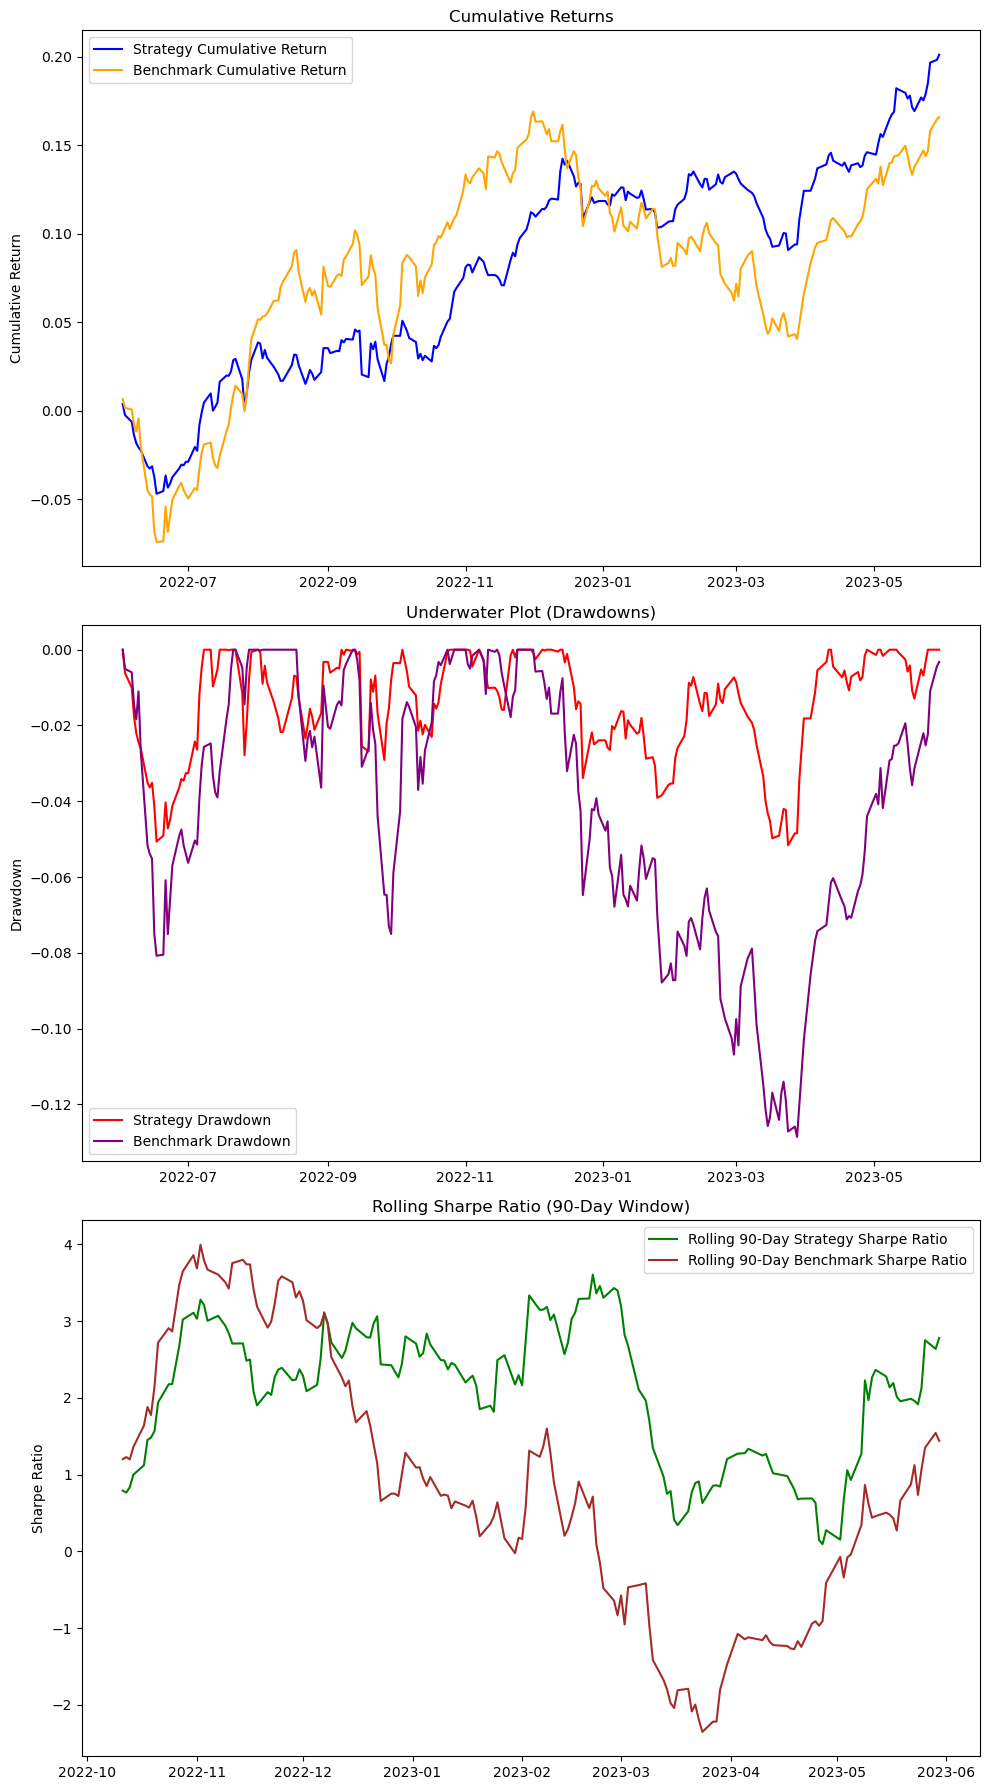

In [53]:
## Minimum Volatility portfolio
backtest_analyser(min_vol_df.min_vol_out_of_sample_ret,ind_df.PX_LAST)

Metric                    Strategy Metrics     Benchmark Metrics   
-----------------------------------------------------------------
Cumulative Return:        12.57%            13.54%
Annualised Return:        13.18%            14.20%
Sharpe Ratio:             1.45            1.12
Max Drawdown:             -7.60%            -12.30%
Max Drawdown Duration:    107 days            118 days
Calmar Ratio:             1.73            1.15
Sortino Ratio:            2.04            1.66


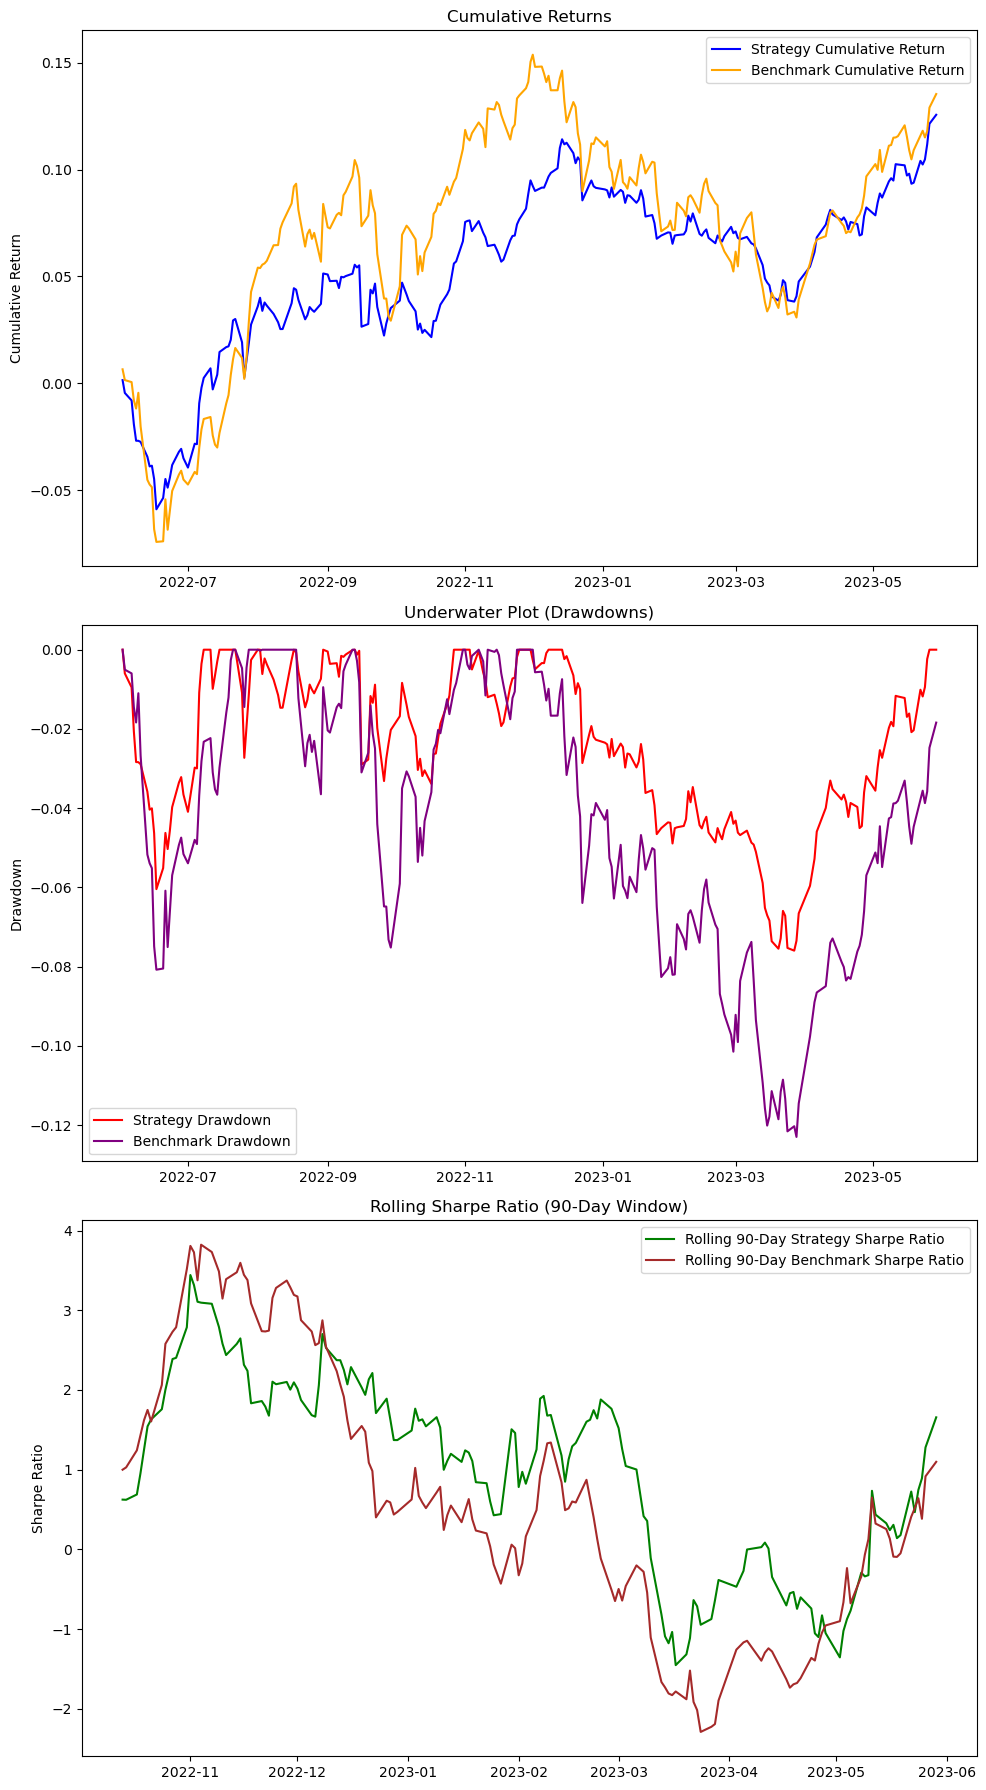

In [56]:
## Equal Weight Portfolio
backtest_analyser(ew_df.ew_ret,ind_df.PX_LAST)

Metric                    Strategy Metrics     Benchmark Metrics   
-----------------------------------------------------------------
Cumulative Return:        13.23%            16.58%
Annualised Return:        13.57%            17.01%
Sharpe Ratio:             1.53            1.31
Max Drawdown:             -8.09%            -12.86%
Max Drawdown Duration:    109 days            121 days
Calmar Ratio:             1.68            1.32
Sortino Ratio:            2.13            2.00


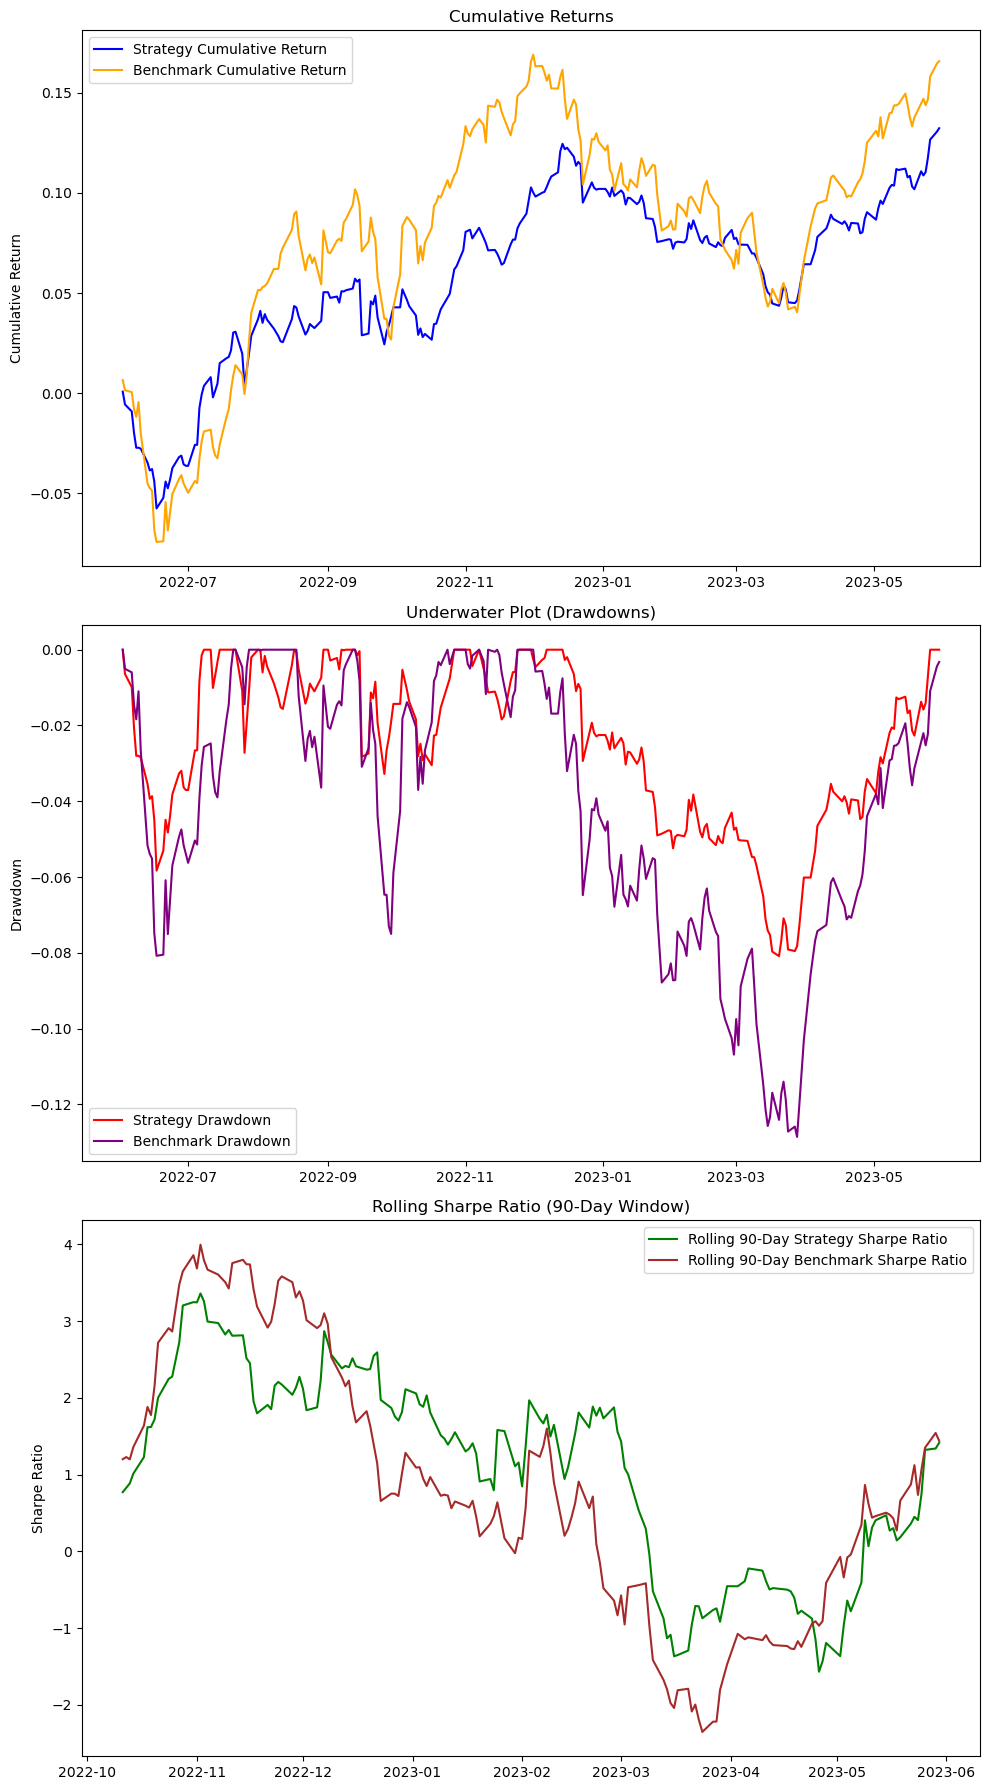

In [58]:
## risk parity portfolio

backtest_analyser(risk_parity_df.rp_out_of_sample_ret,ind_df.PX_LAST)